In [40]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt
import hvplot.pandas

## Reflect Tables into SQLALchemy ORM

In [41]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# View all of the classes that automap found
Base.classes.keys()

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

## Temperature Analysis II

In [42]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [43]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_date = '2017-08-01'
end_date = '2017-08-07'

calculated_temps = calc_temps(start_date,end_date)
print(calculated_temps)

[(72.0, 79.25, 83.0)]


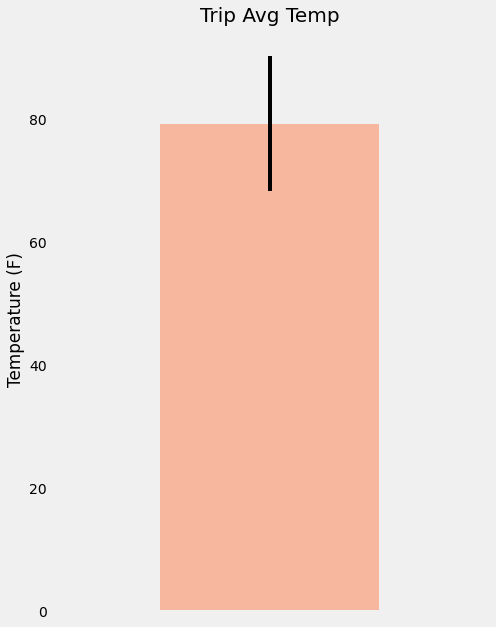

In [44]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_df = pd.DataFrame(calculated_temps,columns=['TMIN','TAVG','TMAX'])
avg_temp = temp_df['TAVG']
min_max_temp = temp_df.iloc[0]['TMAX'] - temp_df.iloc[0]['TMIN']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(7,10), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temperature (F)")
plt.xticks([])
plt.grid()
# plt.savefig("Output/TripTempSummary.png")
plt.show()

### Daily Rainfall Average

In [45]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station,func.sum(Measurement.prcp),\
       Station.name,Station.latitude,Station.longitude,Station.elevation]

prec_data = session.query(*sel).filter(Measurement.station==Station.station).\
                    filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).\
                    group_by(Measurement.station).\
                    order_by(func.sum(Measurement.prcp).desc()).all()

In [46]:
prec_data

[('USC00516128', 0.36, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00514830', 0.22, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('USC00519281', 0.06, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 0.04, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523', 0.0, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)]

In [47]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [48]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
import datetime
start_date2 = datetime.datetime.strptime(start_date, '%Y-%m-%d')
end_date2 = datetime.datetime.strptime(end_date, '%Y-%m-%d')

date_list = []
tmin_list = []
tavg_list = []
tmax_list = []

for x in range(int((end_date2-start_date2).days)+1):
    date = start_date2 + datetime.timedelta(days=x)

    # Strip off the year and save a list of strings in the format %m-%d
    month_and_day = date.strftime("%m-%d")
    date_list.append(date)

    # Use the `daily_normals` function to calculate the normals for each date string 
    # and append the results to a list called `normals`.
    daily_normal = daily_normals(month_and_day)
    tmin = daily_normal[0][0]
    tavg = daily_normal[0][1]
    tmax = daily_normal[0][2]
    tmin_list.append(tmin)
    tavg_list.append(tavg)
    tmax_list.append(tmax)

# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
mult_list = {'Date':date_list,'Min_Temp':tmin_list,'Avg_Temp':tavg_list,'Max_Temp':tmax_list,}
df = pd.DataFrame(mult_list)
df.set_index('Date', inplace=True)
df

,Min_Temp,Avg_Temp,Max_Temp
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


In [49]:
# Plot the daily normals as an area plot with `stacked=False`

df.hvplot.area(width=800, height=400,
               grid=True, alpha=0.15, stacked=False,
               line_width=4, line_color=['blue','red','orange'],
               fill_color=['blue','red','orange'], ylabel='Temperature')

:NdOverlay   [Variable]
   :Area   [Date]   (value)

## Close Session

In [50]:
session.close()